# **Image Colorization**

Task: To Convert a grayscale image into color image using  deep learning approach.

This code is inspired by [DigitalSreeni- Application of Autoencoders](https://www.youtube.com/watch?v=EujccFRio7o&t=389s)

Modification:

*   Own dataset
*   Shuffle the image data for model training to avoid bias and overfitting
*   Regularization
*   Parameter tuning
*   Early stopping





# **1. Mount the Google Colab with Google Drive by sign in to your e-mail account.**

In [ ]:
# Mount to Google drive
from google.colab import drive
drive.mount("/content/gdrive/")

# **2. Change directory to designated image dataset repository.**

*  %cd - change directory
*  %pwd - to check current directory location 

In [ ]:
# Change directory
%cd gdrive
%cd My Drive
%cd Colorization
%pwd

# **3. Import all the required libraries and its functions**



*   Tensorflow
*   Keras
*   Numpy
*   Scikit Image
*   Miscellaneous operating system interfaces (OS)



In [ ]:
# Import libraries
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.regularizers import l2

# **4. Apply ImageDataGenerator function for image normalization.**
 
Rescale by 255 as the image RGB value has range of 0 to 255.

In [ ]:
# Construct image dataset and normaliztion
train_datagen = ImageDataGenerator(rescale=1. / 255)

# **5. Load the image dataset from the path and resize all the loaded image and compile them into image batch.**


*   Image Size : 256 x 256
*   Batch Size : 30



Note: Larger image size and batch size may require more processing power during model training. Also, it might takes longer time as well. However, larger image size and batch size may carry more information for model training. 


In [ ]:
# Load and resize image data
path = './data/train/'
train = train_datagen.flow_from_directory(path,
                                          target_size=(256, 256),
                                          batch_size=30,
                                          shuffle = True,
                                          class_mode=None)

# **6. Convert RGB values into LAB color space value.**



*   L - lightness
*   A - Red/Green Values
*   B - Blue/Yellow Values


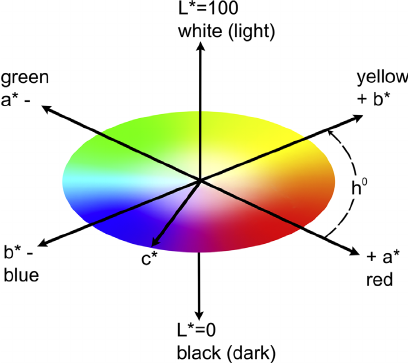



A and B values are in range of -127 to 128, thus, devide by 128 to constrain the values between -1 to 1. 

Moreover, image vaues are sperate in to X and Y array. 

X represent the grayscale image which consist of only L values, while Y array consists of A and B values. We are going to feed the model with X, Y values will be the labels.

In [ ]:
# Convert the RGB channels into LAB channels
# Split the training features(X) and labels (Y)
X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0])
      Y.append(lab[:,:,1:] / 128) 
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) # Dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

# **7. Construct autoendcoder Network**

1.   List item
2.   List item



The model oonsists of encoder and decoder, which has the symmetrical shape. 

Encoder "compress" the image in to a lower dimensional representation anf decoder construct the output by given code derive from the bottleneck of the network.

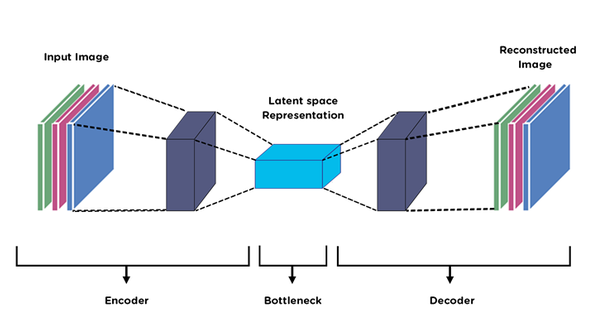



*   13 Convolutional layers
*   3 x strides for downsampling and 3 x upSampling2D to construct the image. 

"tanh" activation function is needed to generate output with range of -1 to 1 with only 2 neurals that return 2 values that represent A and B channels.



In [ ]:
# Autoencoder Network

# Construct a network
model = Sequential()

# Encoder
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

# Decoder
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=l2(0.0005)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((1, 1)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])

# Observe the network structure
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 512)       1180160   
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 512)       2

# **8. Model Training**

Training set to run for 3000 epoches and 60 images for training per batch. X is serve as input and Y is the prediction output.

Lastly, model save at the written path and its ready for prediction and image colorization. 

In [ ]:
# Model training 
model.fit(X,Y, epochs=3000, batch_size=60)

model.save('./model/colorize_autoencoder_sunet.model')

# **9. Load the model from the given directory and file name.** 

In [ ]:
# Load trained model
model = tf.keras.models.load_model(
    './model/colorize_autoencoder_sunet.model',
    custom_objects=None,
    compile=True)

# **10. Model Testing**

Finally, load the testing dataset from path. Then, resize and convert the image into grayscale and give image size (256 x 256).

In [ ]:
path = './testing/'
files = os.listdir(path)
for idx, file in enumerate(files):
    img1_color=[]
    img1=img_to_array(load_img(path+file))
    img1 = resize(img1 ,(256,256), anti_aliasing=True)
    img1_color.append(img1)
    img1_color = np.array(img1_color, dtype=float)
    img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
    img1_color = img1_color.reshape(img1_color.shape+(1,))
    output1 = model.predict(img1_color)

    # Output values are (-1, 1), thus multiply by 128 to return to original A B values.
    output1 = output1*128 

    # Insert the origical L values at the 0 channel and output at the 1 and 2 channel.
    result = np.zeros((256, 256, 3))
    result[:,:,0] = img1_color[0][:,:,0]
    result[:,:,1:] = output1[0]
    
    # Image saved at location path below.
    imsave('results/result' + str(idx) + ".jpg", lab2rgb(result))
print("Completed!")